In [36]:
import s3fs
import numcodecs as ncd
import numpy as np
import datetime
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
# import matplotlib as mpl
# import matplotlib.animation as animation
import matplotlib.dates as mdates
# import matplotlib.colors as colors
# import os.path 
# from datetime import datetime,timedelta
# import numpy as np
# import pandas as pd
# from scipy import interpolate
# import glob
# import pickle
# from datetime import timedelta
# import datetime as dt
import requests
import os
# import json
# from herbie import Herbie,wgrib2
# import pygrib
# import urllib
# import urllib.request as urllib2
# from bs4 import BeautifulSoup

fs = s3fs.S3FileSystem(anon=True)

In [91]:
from datetime import datetime

#location: Example is Salt Lake City (SLC). Can only do coordinates in area that is covered by the HRRR CONUS grid.
point_lat = 40.7608
point_lon = -111.8910

# Date: [YYYYMMDD] must be in this format. Example is for Aug 21, 2024
date = '20240821'
date_obj = datetime.strptime(date, '%Y%m%d')
date2 = '20240823'
date_obj2 = datetime.strptime(date2, '%Y%m%d')

# Hour: [00-23]z must be in the two digit format  i.e. 06 or 19
hr = '00'
hr_obj = datetime.strptime(hr, '%H')

# Level: 
level = 'surface'

# Variable:
var = 'TMP'

data_url = f'hrrrzarr/sfc/{date}/{date}_{hr}z_fcst.zarr/{level}/{var}/{level}/{var}/'
data_url2 = f'hrrrzarr/sfc/{date2}/{date2}_{hr}z_fcst.zarr/{level}/{var}/{level}/{var}/'

In [92]:
chunk_index = xr.open_zarr(s3fs.S3Map("s3://hrrrzarr/grid/HRRR_chunk_index.zarr", s3=fs))
# This is the projection the HRRR grid uses.
projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))

x, y = projection.transform_point(point_lon, point_lat, ccrs.PlateCarree())

nearest_point = chunk_index.sel(x=x, y=y, method="nearest")
fcst_chunk_id = f"0.{nearest_point.chunk_id.values}"

In [93]:
%%time
def retrieve_data(s3_url):
    with fs.open(s3_url, 'rb') as compressed_data: # using s3fs
        buffer = ncd.blosc.decompress(compressed_data.read())

        dtype = "<f4" # See variables background page and python data loading
                      # guide for info on when you need a different dtype

        chunk = np.frombuffer(buffer, dtype=dtype)
        
        entry_size = 150*150
        num_entries = len(chunk)//entry_size

        if num_entries == 1: # analysis file is 2d
            data_array = np.reshape(chunk, (150, 150))
        else:
            data_array = np.reshape(chunk, (num_entries, 150, 150))

    return data_array
data = retrieve_data(data_url + fcst_chunk_id)
data2 = retrieve_data(data_url2 + fcst_chunk_id)
# print(data.shape)

CPU times: user 49.8 ms, sys: 40.9 ms, total: 90.6 ms
Wall time: 1.53 s


In [94]:
print(data.shape)
print(data2.shape)


(48, 150, 150)
(48, 150, 150)


In [95]:
gridpoint_forecast = data[:, nearest_point.in_chunk_y, nearest_point.in_chunk_x]
gridpoint_forecast2 = data2[:, nearest_point.in_chunk_y, nearest_point.in_chunk_x]
import pandas as pd

end_datetime = date_obj + pd.DateOffset(hours=47)
datetime_range = pd.date_range(start=date_obj, end=end_datetime, freq='H')
end_datetime2 = date_obj2 + pd.DateOffset(hours=47)
datetime_range2 = pd.date_range(start=date_obj2, end=end_datetime2, freq='H')
print(datetime_range)


DatetimeIndex(['2024-08-21 00:00:00', '2024-08-21 01:00:00',
               '2024-08-21 02:00:00', '2024-08-21 03:00:00',
               '2024-08-21 04:00:00', '2024-08-21 05:00:00',
               '2024-08-21 06:00:00', '2024-08-21 07:00:00',
               '2024-08-21 08:00:00', '2024-08-21 09:00:00',
               '2024-08-21 10:00:00', '2024-08-21 11:00:00',
               '2024-08-21 12:00:00', '2024-08-21 13:00:00',
               '2024-08-21 14:00:00', '2024-08-21 15:00:00',
               '2024-08-21 16:00:00', '2024-08-21 17:00:00',
               '2024-08-21 18:00:00', '2024-08-21 19:00:00',
               '2024-08-21 20:00:00', '2024-08-21 21:00:00',
               '2024-08-21 22:00:00', '2024-08-21 23:00:00',
               '2024-08-22 00:00:00', '2024-08-22 01:00:00',
               '2024-08-22 02:00:00', '2024-08-22 03:00:00',
               '2024-08-22 04:00:00', '2024-08-22 05:00:00',
               '2024-08-22 06:00:00', '2024-08-22 07:00:00',
               '2024-08-

(array([19956. , 19956.5, 19957. , 19957.5, 19958. , 19958.5, 19959. ,
        19959.5, 19960. ]),
 [Text(19956.0, 0, '08-21 00'),
  Text(19956.5, 0, '08-21 12'),
  Text(19957.0, 0, '08-22 00'),
  Text(19957.5, 0, '08-22 12'),
  Text(19958.0, 0, '08-23 00'),
  Text(19958.5, 0, '08-23 12'),
  Text(19959.0, 0, '08-24 00'),
  Text(19959.5, 0, '08-24 12'),
  Text(19960.0, 0, '08-25 00')])

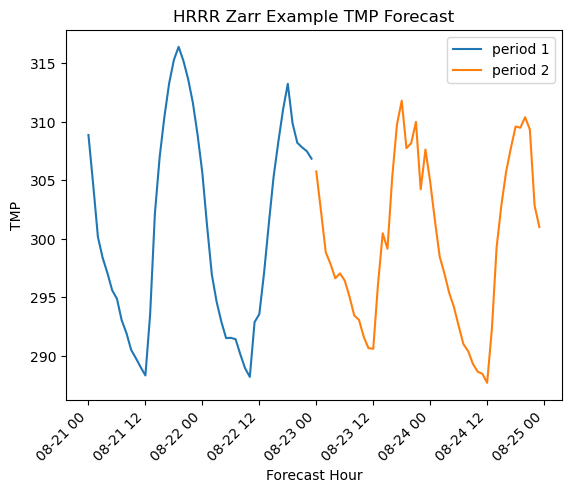

In [96]:
plt.title('HRRR Zarr Example %s Forecast' %(var))
plt.xlabel('Forecast Hour')
plt.ylabel(var)
plt.plot(datetime_range,gridpoint_forecast)
plt.plot(datetime_range2,gridpoint_forecast2)
plt.legend(['period 1','period 2'])
plt.xticks(rotation=45, ha='right')

In [98]:
API_ROOT = "https://api.synopticdata.com/v2/"
API_TOKEN = "57099309cc0f4020a75285e0ea2a233b"

date_range = ['202408210000','202408242359'] # start time and end time

In [99]:

API_ROOT = "https://api.synopticdata.com/v2/"
api_request_url = os.path.join(API_ROOT, "stations/timeseries?start=202408210000&end=202408242359&vars=air_temp")
api_arguments = {"token":API_TOKEN,"stid":"kslc"}
req = requests.get(api_request_url, params=api_arguments)
reqj = req.json()
# print(reqj['STATION'][0]['OBSERVATIONS']) # format for reading data from json file

datetimes = pd.to_datetime(reqj['STATION'][0]['OBSERVATIONS']['date_time']) # datetime read
temperature = reqj['STATION'][0]['OBSERVATIONS']['air_temp_set_1'] # temperature in C

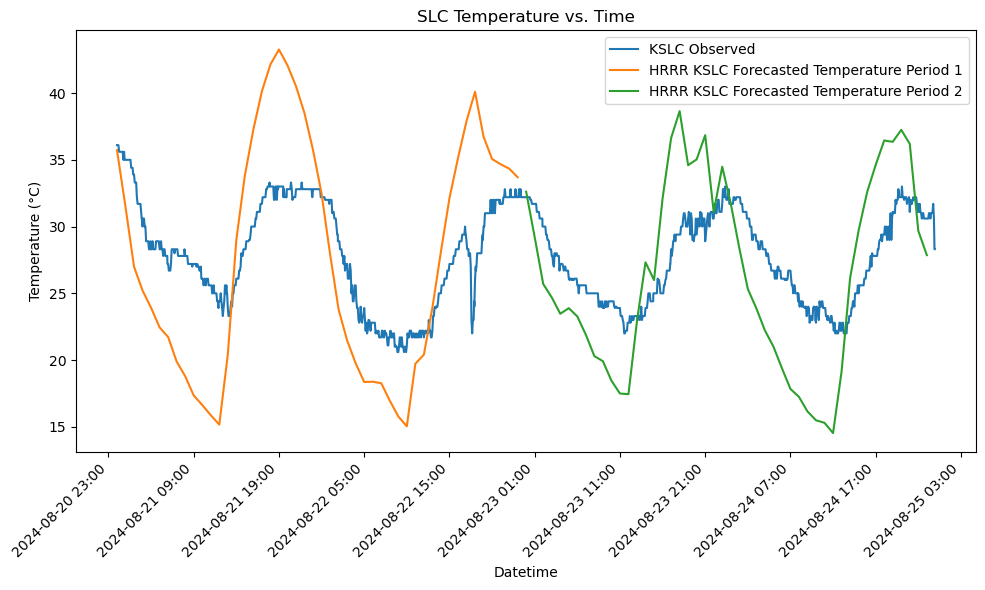

In [101]:
# print(pd.to_datetime(dt))

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(datetimes, temperature)
plt.plot(datetime_range, gridpoint_forecast-273.15)
plt.plot(datetime_range2, gridpoint_forecast2-273.15)
# Set the x-axis major locator to show every 10th datetime tick
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=10))

# Format the datetime labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# Rotate x-axis labels at a 45-degree angle
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.title('SLC Temperature vs. Time')
plt.legend(['KSLC Observed','HRRR KSLC Forecasted Temperature Period 1','HRRR KSLC Forecasted Temperature Period 2'])

# Tight layout to avoid label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [105]:
import pandas as pd
import numpy as np

# Example data: two datetime ranges
low_res_range = datetime_range.tz_localize('UTC')
low_res_range2 = datetime_range2.tz_localize('UTC')
high_res_range = datetimes

# Low-resolution data (daily values)
low_res_values = gridpoint_forecast
low_res_values2 = gridpoint_forecast2

# Create a DataFrame for low-resolution data
low_res_df = pd.DataFrame({
    'datetime': low_res_range,
    'value': low_res_values
})
low_res_df2 = pd.DataFrame({
    'datetime': low_res_range2,
    'value': low_res_values2
})
# Set the 'datetime' column as the index
low_res_df.set_index('datetime', inplace=True)
low_res_df2.set_index('datetime', inplace=True)

# Find the overlapping range between low_res_range and high_res_range
overlap_start = max(low_res_range.min(), high_res_range.min())
overlap_end = min(low_res_range.max(), high_res_range.max())

overlap_start2 = max(low_res_range2.min(), high_res_range.min())
overlap_end2 = min(low_res_range2.max(), high_res_range.max())

# Slice the high_res_range to the overlapping period
high_res_range_overlap = high_res_range[(high_res_range >= overlap_start) & (high_res_range <= overlap_end)]
high_res_overlap_ind = (high_res_range >= overlap_start) & (high_res_range <= overlap_end)

high_res_range_overlap2 = high_res_range[(high_res_range >= overlap_start2) & (high_res_range <= overlap_end2)]
high_res_overlap_ind2 = (high_res_range >= overlap_start2) & (high_res_range <= overlap_end2)

# Reindex the low-resolution data to the overlapping high-resolution range and interpolate
high_res_df = low_res_df.reindex(high_res_range_overlap).interpolate(method='linear')
high_res_df2 = low_res_df2.reindex(high_res_range_overlap2).interpolate(method='linear')

# Display the interpolated high-resolution data
print(high_res_df)
print(high_res_range_overlap)


                                value
2024-08-21 00:00:00+00:00  308.873138
2024-08-21 00:05:00+00:00  308.545898
2024-08-21 00:10:00+00:00  308.218658
2024-08-21 00:15:00+00:00  307.891418
2024-08-21 00:20:00+00:00  307.564178
...                               ...
2024-08-22 22:45:00+00:00  307.044708
2024-08-22 22:50:00+00:00  306.995056
2024-08-22 22:54:00+00:00  306.945435
2024-08-22 22:55:00+00:00  306.895813
2024-08-22 23:00:00+00:00  306.846191

[615 rows x 1 columns]
DatetimeIndex(['2024-08-21 00:00:00+00:00', '2024-08-21 00:05:00+00:00',
               '2024-08-21 00:10:00+00:00', '2024-08-21 00:15:00+00:00',
               '2024-08-21 00:20:00+00:00', '2024-08-21 00:25:00+00:00',
               '2024-08-21 00:30:00+00:00', '2024-08-21 00:35:00+00:00',
               '2024-08-21 00:40:00+00:00', '2024-08-21 00:45:00+00:00',
               ...
               '2024-08-22 22:20:00+00:00', '2024-08-22 22:25:00+00:00',
               '2024-08-22 22:30:00+00:00', '2024-08-22 22:35:0

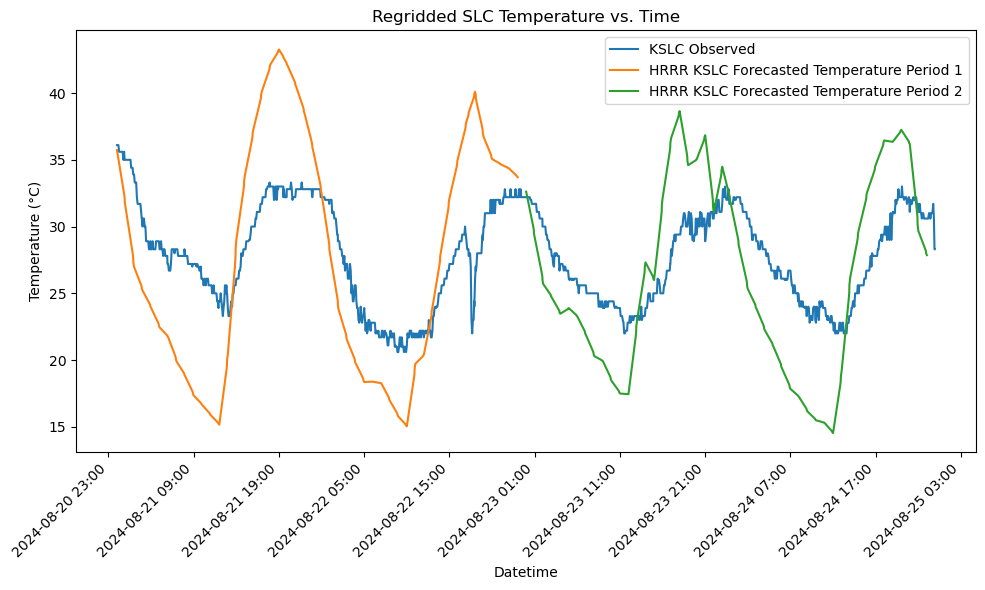

In [108]:
# print(pd.to_datetime(dt))

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(datetimes, temperature)
plt.plot(high_res_range_overlap, high_res_df-273.15)
plt.plot(high_res_range_overlap2, high_res_df2-273.15)

# Set the x-axis major locator to show every 10th datetime tick
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=10))

# Format the datetime labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# Rotate x-axis labels at a 45-degree angle
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.title('Regridded SLC Temperature vs. Time')
plt.legend(['KSLC Observed','HRRR KSLC Forecasted Temperature Period 1','HRRR KSLC Forecasted Temperature Period 2'])

# Tight layout to avoid label cutoff
plt.tight_layout()

# Show the plot
plt.show()



In [111]:
print(high_res_overlap_ind)

[ True  True  True ... False False False]


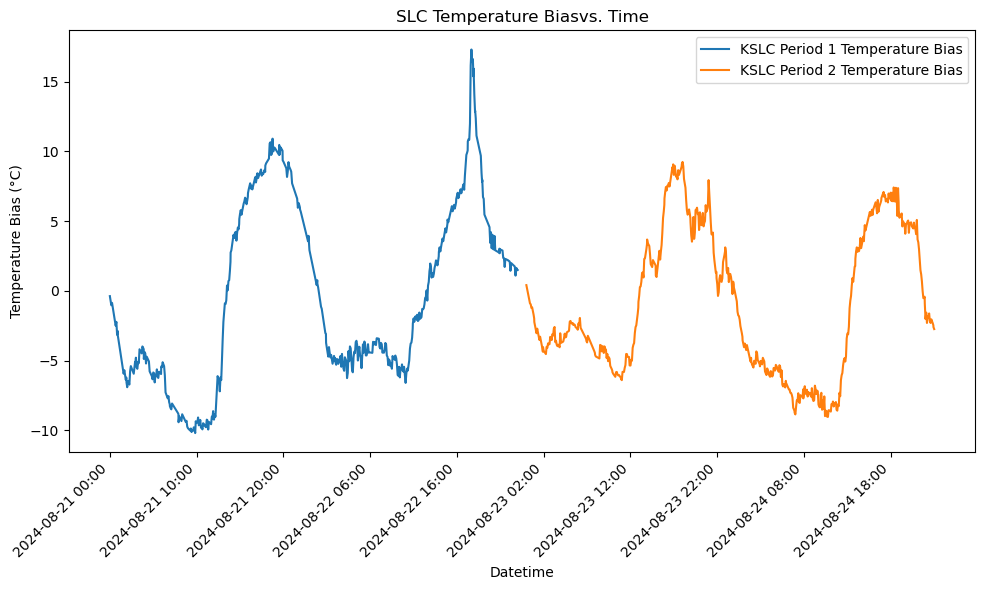

In [114]:
# print(high_res_df.shape)
# print(np.array(temperature[0:615]).shape)
bias = np.array(high_res_df)[:,0]-273.15-np.array(temperature)[high_res_overlap_ind]
bias2 = np.array(high_res_df2)[:,0]-273.15-np.array(temperature)[high_res_overlap_ind2]

# print(np.array(high_res_df)-273.15-np.array(temperature[0:615]))
plt.figure(figsize=(10, 6))
# plt.plot(datetimes, temperature)
# plt.plot(high_res_range_overlap, np.array(high_res_df))
plt.plot(high_res_range_overlap, np.array(bias))
plt.plot(high_res_range_overlap2, np.array(bias2))

# Set the x-axis major locator to show every 10th datetime tick
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=10))

# Format the datetime labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# Rotate x-axis labels at a 45-degree angle
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Datetime')
plt.ylabel('Temperature Bias (°C)')
plt.title('SLC Temperature Biasvs. Time')
plt.legend(['KSLC Period 1 Temperature Bias','KSLC Period 2 Temperature Bias'])

# Tight layout to avoid label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [209]:
import pandas as pd
import numpy as np

# Create a sample datetime range (hourly frequency)
date_range = high_res_range_overlap

# Create a corresponding dataset (for example, random values)
data = np.array(high_res_df)[:,0]-273.15
g_data = np.gradient(data,1)

# Create a DataFrame with the date range and dataset
df = pd.DataFrame({'datetime': date_range, 'value': data})
bias_df = pd.DataFrame({'datetime': date_range, 'value': bias})
grad_df = pd.DataFrame({'datetime': date_range, 'value': g_data})

# Set the 'datetime' column as the index
df.set_index('datetime', inplace=True)
bias_df.set_index('datetime', inplace=True)
grad_df.set_index('datetime', inplace=True)

# Compute the average value for each hour of the day
hourly_avg = df.groupby(df.index.hour).mean()
bias_hourly_avg = bias_df.groupby(bias_df.index.hour).mean()
grad_hourly_avg = np.abs(grad_df.groupby(grad_df.index.hour).mean())

print(bias_hourly_avg.shape)
# Add the corresponding hourly average to the data that resides in that hour
# We use df.index.hour to map each row to its corresponding hour
df['hourly_adjusted_value'] = df['value'] - df.index.hour.map(bias_hourly_avg['value']) # this is the corrected values after only calculating a bias from what hour of day
bias_df['hourly_adjusted_value'] = bias_df['value'] + bias_df.index.hour.map(hourly_avg['value'])

# Print the updated DataFrame
# print(df)
# print(bias_df)
print(grad_hourly_avg)

(24, 1)
             value
datetime          
0         0.336263
1         0.331978
2         0.163983
3         0.117031
4         0.110651
5         0.030145
6         0.073105
7         0.091600
8         0.100762
9         0.057582
10        0.142857
11        0.004805
12        0.324456
13        0.485659
14        0.345085
15        0.251609
16        0.217676
17        0.158312
18        0.074699
19        0.104793
20        0.076368
21        0.090029
22        0.129331
23        0.234986


In [210]:
import pandas as pd
import numpy as np

date_range2 = high_res_range_overlap2
pre_data = np.array(high_res_df2)[:,0]-273.15
# Step 1: Create a sample datetime range at 5-minute intervals

predict_date_range = date_range2

# Step 2: Create a sample list of values at 5-minute intervals
values = pre_data

# Step 3: Create a list of bias correction values (one for each hour)
# Example: Random bias correction values for each hour (0 to 23)
bias_corrections = bias_hourly_avg

# print(bias_hourly_avg)

# Step 4: Create a DataFrame to hold the values and corresponding datetime
predict_df = pd.DataFrame({'datetime': date_range2, 'value': pre_data})

# Set the 'datetime' column as the index
predict_df.set_index('datetime', inplace=True)

# print(bias_corrections['value'][0])
# Step 5: Add the corresponding bias correction value to each value
# We use df.index.hour to access the hour for each 5-minute interval
# predict_df['corrected_value'] = predict_df['value'] - predict_df.index.hour.map(lambda hour: bias_corrections['value'][hour])
# predict_df['corrected_value'] = predict_df['value'] - predict_df.index.hour.map(lambda hour: bias_corrections['value'][hour])
predict_df['hourly_adjusted_value'] = predict_df['value'] - predict_df.index.hour.map(bias_hourly_avg['value']) # this is the corrected values after only calculating a bias from what hour of day

# Print the updated DataFrame
print(predict_df[['value', 'hourly_adjusted_value']])


                               value  hourly_adjusted_value
datetime                                                   
2024-08-23 00:00:00+00:00  32.611664              34.363501
2024-08-23 00:05:00+00:00  32.349243              34.101081
2024-08-23 00:10:00+00:00  32.086792              33.838630
2024-08-23 00:15:00+00:00  31.824371              33.576209
2024-08-23 00:20:00+00:00  31.561920              33.313758
...                              ...                    ...
2024-08-24 22:45:00+00:00  28.419250              25.294363
2024-08-24 22:50:00+00:00  28.279205              25.154318
2024-08-24 22:54:00+00:00  28.139130              25.014242
2024-08-24 22:55:00+00:00  27.999084              24.874197
2024-08-24 23:00:00+00:00  27.859039              26.350759

[612 rows x 2 columns]


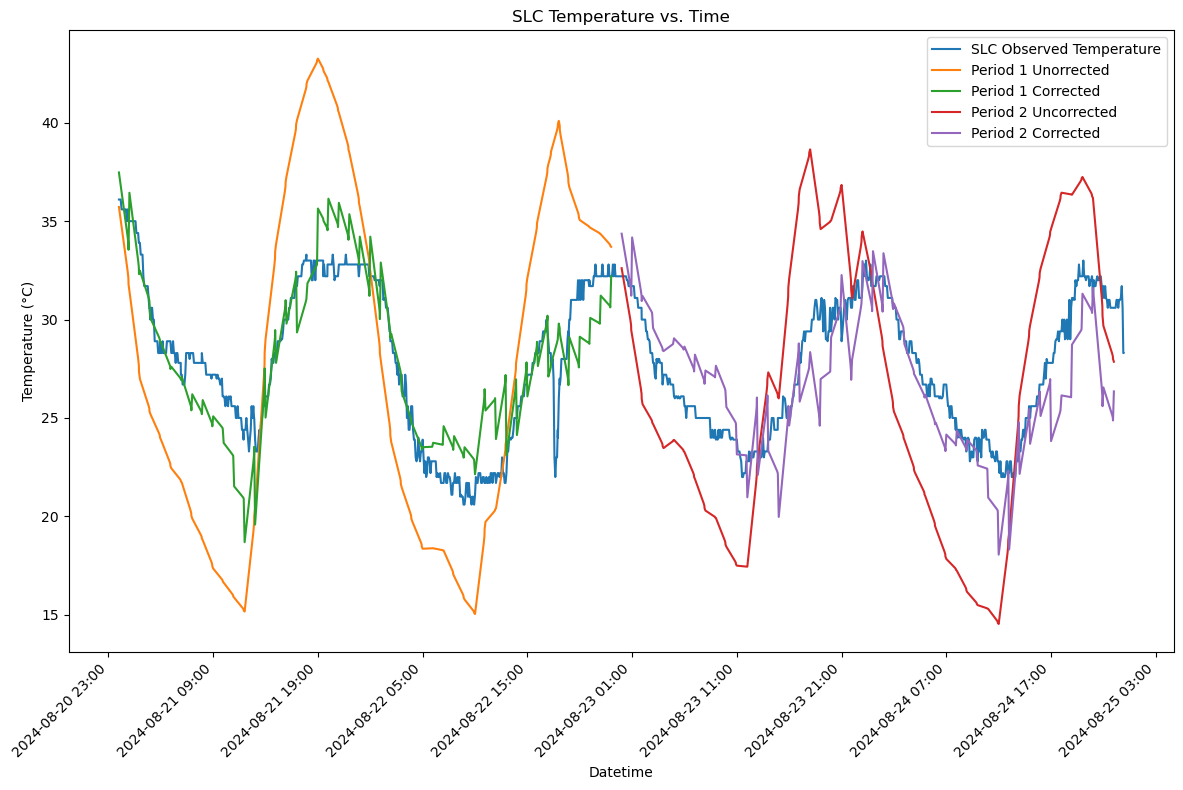

In [211]:
plt.figure(figsize=(12, 8))
# plt.plot(datetimes, temperature)
# plt.plot(high_res_range_overlap, np.array(high_res_df)-273.15)
# plt.plot(high_res_range_overlap, np.array(bias))
plt.plot(datetimes, temperature)

plt.plot(high_res_range_overlap, df['value'])
plt.plot(high_res_range_overlap, df['hourly_adjusted_value'])
plt.plot(high_res_range_overlap2, predict_df['value'])
plt.plot(high_res_range_overlap2, predict_df['hourly_adjusted_value'])

# Set the x-axis major locator to show every 10th datetime tick
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=10))

# Format the datetime labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# Rotate x-axis labels at a 45-degree angle
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.title('SLC Temperature vs. Time')
plt.legend(['SLC Observed Temperature','Period 1 Unorrected','Period 1 Corrected','Period 2 Uncorrected','Period 2 Corrected'])

# Tight layout to avoid label cutoff
plt.tight_layout()

# Show the plot
plt.show()


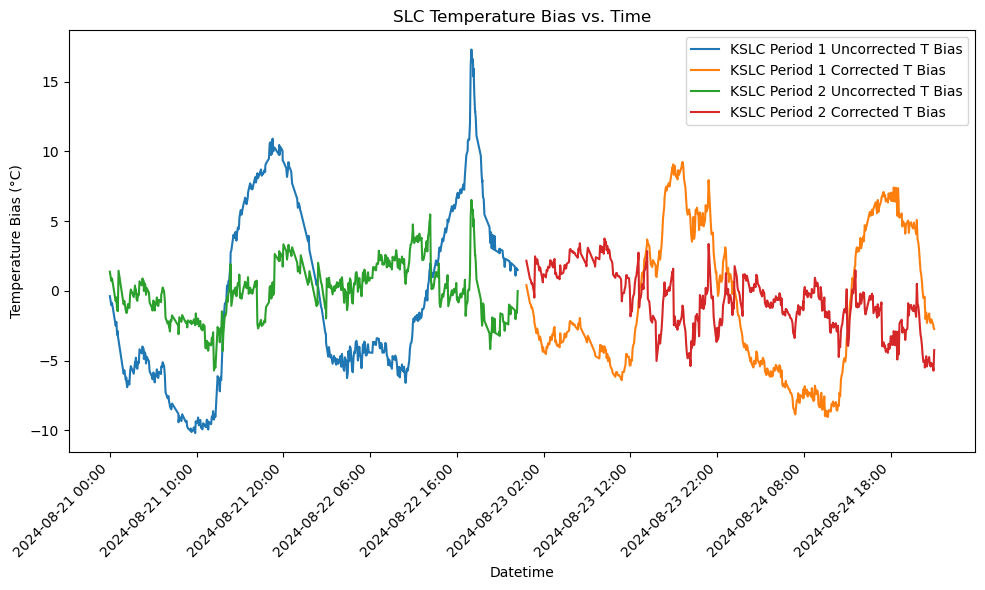

In [212]:
# print(high_res_df.shape)
# print(np.array(temperature[0:615]).shape)
bias = np.array(df['value'])-np.array(temperature)[high_res_overlap_ind]
bias2 = np.array(predict_df['value'])-np.array(temperature)[high_res_overlap_ind2]
cbias = np.array(df['hourly_adjusted_value'])-np.array(temperature)[high_res_overlap_ind]
cbias2 = np.array(predict_df['hourly_adjusted_value'])-np.array(temperature)[high_res_overlap_ind2]
# print(np.array(high_res_df)-273.15-np.array(temperature[0:615]))
plt.figure(figsize=(10, 6))
# plt.plot(datetimes, temperature)
# plt.plot(high_res_range_overlap, np.array(high_res_df))
plt.plot(high_res_range_overlap, np.array(bias))
plt.plot(high_res_range_overlap2, np.array(bias2))
plt.plot(high_res_range_overlap, np.array(cbias))
plt.plot(high_res_range_overlap2, np.array(cbias2))

# Set the x-axis major locator to show every 10th datetime tick
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=10))

# Format the datetime labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# Rotate x-axis labels at a 45-degree angle
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Datetime')
plt.ylabel('Temperature Bias (°C)')
plt.title('SLC Temperature Bias vs. Time')
plt.legend(['KSLC Period 1 Uncorrected T Bias','KSLC Period 1 Corrected T Bias','KSLC Period 2 Uncorrected T Bias','KSLC Period 2 Corrected T Bias'])

# Tight layout to avoid label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [213]:
import pandas as pd
import numpy as np

def smooth_time_series(data, thresholds):
    smoothed_data = data.copy()  # Create a copy of the original data

    for i in range(1, len(smoothed_data)):
        current_hour = smoothed_data.index[i].hour  # Get the current hour
        threshold = thresholds[current_hour]  # Get the corresponding threshold for this hour

        # Calculate the difference
        diff = smoothed_data[i] - smoothed_data[i - 1]

        # If the difference exceeds the threshold, smooth the value
        if abs(diff) > threshold:
            if diff > 0:
                # Limit the current value to the previous value + threshold
                smoothed_data[i] = smoothed_data[i - 1] + threshold
            else:
                # Limit the current value to the previous value - threshold
                smoothed_data[i] = smoothed_data[i - 1] - threshold

    return smoothed_data

# Step 1: Create a sample datetime range (hourly frequency)
date_range = predict_date_range

# Step 2: Create a list of random values for demonstration
values = predict_df['hourly_adjusted_value']

# Step 3: Create a DataFrame with the date range and values
smooth_df = pd.DataFrame({'value': values}, index=date_range)

# Step 4: Create a list of threshold values for each hour of the day
# Example: Random thresholds for each hour (0 to 23)
thresholds = grad_hourly_avg
# print(thresholds['value'])
# Step 5: Apply smoothing
smoothed_values = smooth_time_series(smooth_df['value'], thresholds['value'])

# Update the DataFrame with smoothed values
smooth_df['smoothed_value'] = smoothed_values

# Print the updated DataFrame
print(smooth_df)

                               value  smoothed_value
2024-08-23 00:00:00+00:00  34.363501       34.363501
2024-08-23 00:05:00+00:00  34.101081       34.101081
2024-08-23 00:10:00+00:00  33.838630       33.838630
2024-08-23 00:15:00+00:00  33.576209       33.576209
2024-08-23 00:20:00+00:00  33.313758       33.313758
...                              ...             ...
2024-08-24 22:45:00+00:00  25.294363       27.024110
2024-08-24 22:50:00+00:00  25.154318       26.894780
2024-08-24 22:54:00+00:00  25.014242       26.765449
2024-08-24 22:55:00+00:00  24.874197       26.636119
2024-08-24 23:00:00+00:00  26.350759       26.401132

[612 rows x 2 columns]


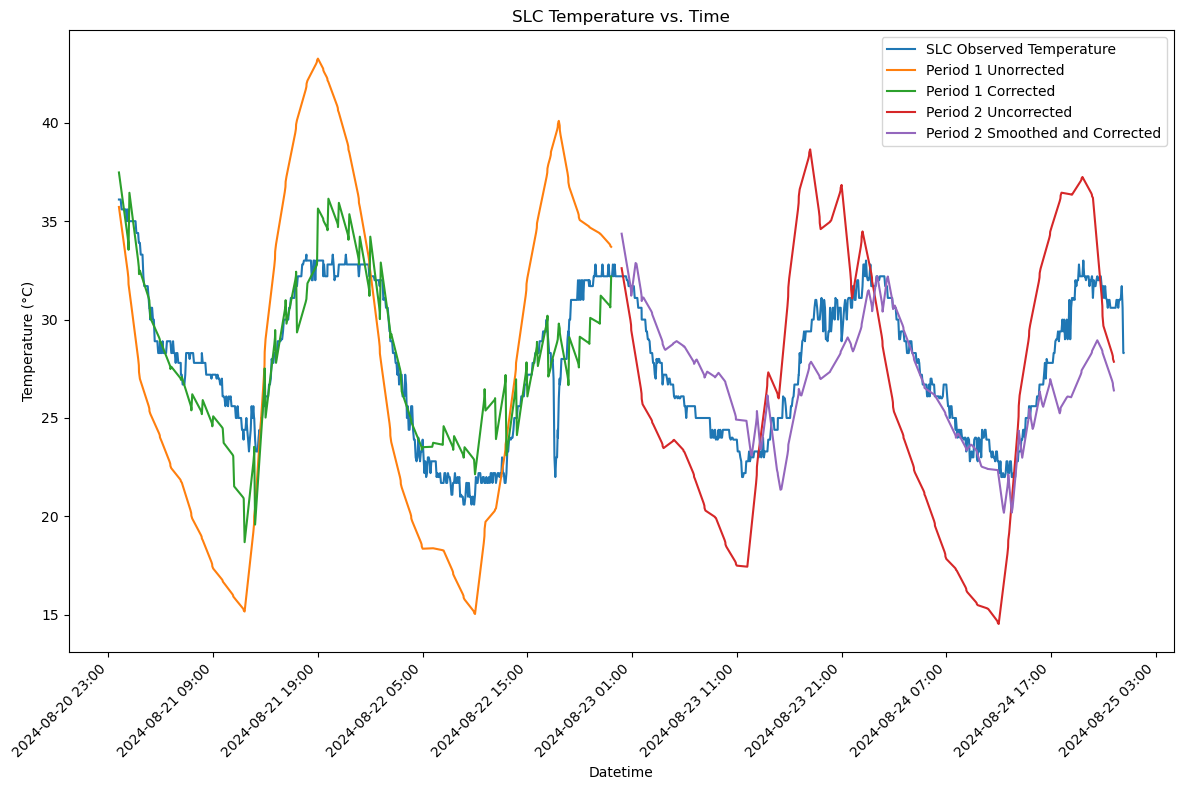

In [218]:
plt.figure(figsize=(12, 8))
# plt.plot(datetimes, temperature)
# plt.plot(high_res_range_overlap, np.array(high_res_df)-273.15)
# plt.plot(high_res_range_overlap, np.array(bias))
plt.plot(datetimes, temperature)

plt.plot(high_res_range_overlap, df['value'])
plt.plot(high_res_range_overlap, df['hourly_adjusted_value'])
plt.plot(high_res_range_overlap2, predict_df['value'])
# plt.plot(high_res_range_overlap2, predict_df['hourly_adjusted_value'])
plt.plot(high_res_range_overlap2, smooth_df['smoothed_value'])

# Set the x-axis major locator to show every 10th datetime tick
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=10))

# Format the datetime labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# Rotate x-axis labels at a 45-degree angle
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.title('SLC Temperature vs. Time')
plt.legend(['SLC Observed Temperature','Period 1 Unorrected','Period 1 Corrected','Period 2 Uncorrected','Period 2 Smoothed and Corrected']) # removed the just corrected

# Tight layout to avoid label cutoff
plt.tight_layout()

# Show the plot
plt.show()


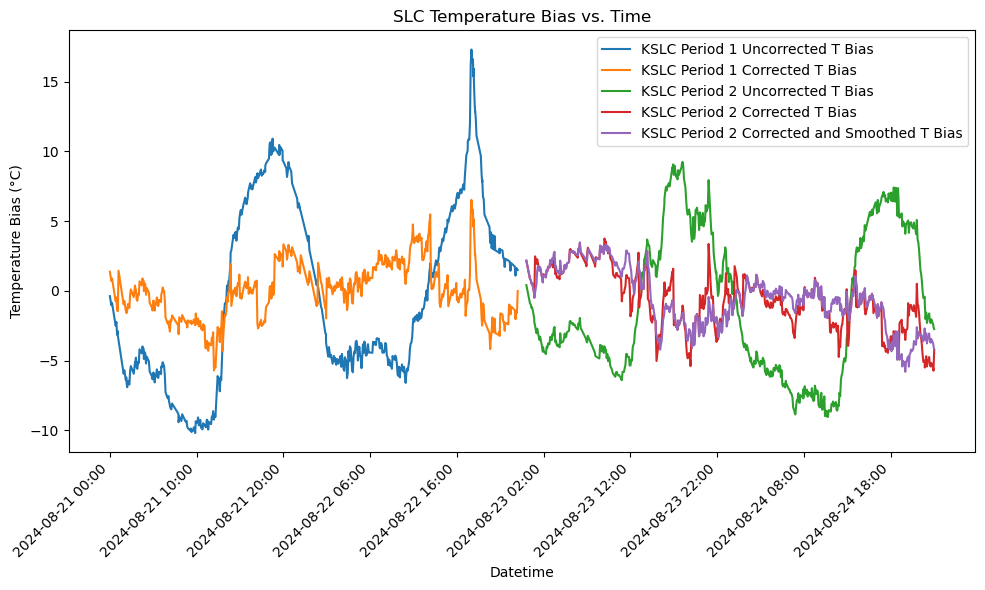

In [220]:
# plt.figure()
# plt.plot(high_res_range_overlap2,smooth_df)
# plt.plot(high_res_range_overlap2,smoothed_values)

# print(high_res_df.shape)
# print(np.array(temperature[0:615]).shape)
bias = np.array(df['value'])-np.array(temperature)[high_res_overlap_ind]
cbias = np.array(df['hourly_adjusted_value'])-np.array(temperature)[high_res_overlap_ind]
bias2 = np.array(predict_df['value'])-np.array(temperature)[high_res_overlap_ind2]
cbias2 = np.array(predict_df['hourly_adjusted_value'])-np.array(temperature)[high_res_overlap_ind2]
cbiass2 = np.array(smooth_df['smoothed_value'])-np.array(temperature)[high_res_overlap_ind2]
# print(np.array(high_res_df)-273.15-np.array(temperature[0:615]))
plt.figure(figsize=(10, 6))
# plt.plot(datetimes, temperature)
# plt.plot(high_res_range_overlap, np.array(high_res_df))
plt.plot(high_res_range_overlap, np.array(bias))
plt.plot(high_res_range_overlap, np.array(cbias))
plt.plot(high_res_range_overlap2, np.array(bias2))
plt.plot(high_res_range_overlap2, np.array(cbias2))
plt.plot(high_res_range_overlap2, np.array(cbiass2))


# Set the x-axis major locator to show every 10th datetime tick
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=10))

# Format the datetime labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# Rotate x-axis labels at a 45-degree angle
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Datetime')
plt.ylabel('Temperature Bias (°C)')
plt.title('SLC Temperature Bias vs. Time')
plt.legend(['KSLC Period 1 Uncorrected T Bias','KSLC Period 1 Corrected T Bias','KSLC Period 2 Uncorrected T Bias','KSLC Period 2 Corrected T Bias','KSLC Period 2 Corrected and Smoothed T Bias'])

# Tight layout to avoid label cutoff
plt.tight_layout()

# Show the plot
plt.show()

There are the following forks that need work:

- Generalizing this such that the correction training happens on a specified timescale before the upcoming forecast, start with -3 day persistance
- Functionalizing this such that for a given forecast hour, a correction matrix can be added to each horizon hour depending on what hour of day the horizon hour is at
- reading in a sounding and doing the same with the sounding at a given location to correct the boundary layer model outputs